In [1]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from data_preprocess import data_preprocess
from feature_extractor import FeatureExtractor
from test_model import test_model

In [2]:
# Load the data and extract gesture segments from the data.
data_path = 'Project_Data_EE4C12_S&S_EMG.csv'
gesture_windows = data_preprocess(data_path)

In [3]:
# Extract features for each gesture
feature_extractor = FeatureExtractor()
features = feature_extractor.extract_features(gesture_windows)

Analyze the class balances using histogram of class samples

gesture
0    926
1    144
2    144
3    144
4    144
5    144
6    144
7      8
Name: count, dtype: int64


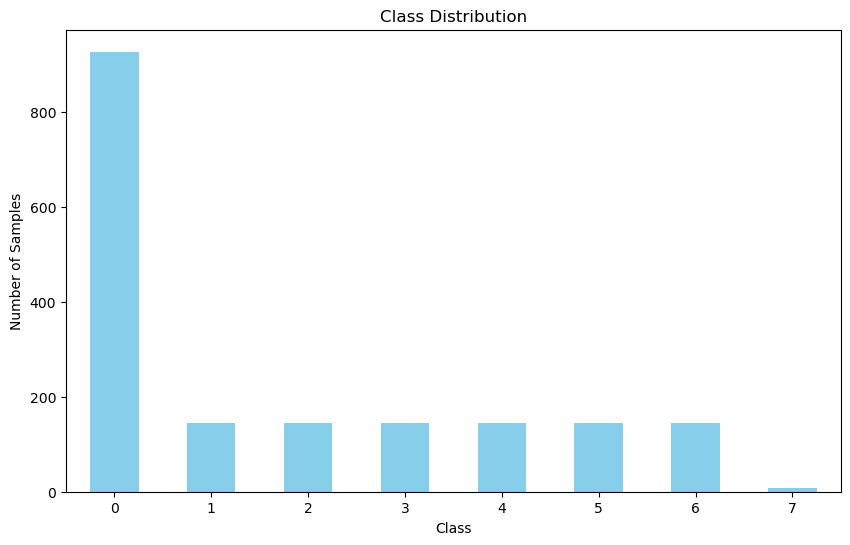

In [4]:
class_balances = features['gesture'].value_counts()
print(class_balances)
plt.figure(figsize=(10, 6))
class_balances.plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.show()

It shows that there are too few samples (8 samples) from class 7. We can give that class a higher weight in the loss functions of the future models but even training might not be good enough with this many samples. So we decided to remove the class 7 from the data.

Also, unmarked data belonging to class 0 dominates other classes in terms of number of samples and generally classifiers work better when all classes are balanced. So we can give it a lower weight or subsample the class 0. We chose to subsample the class.

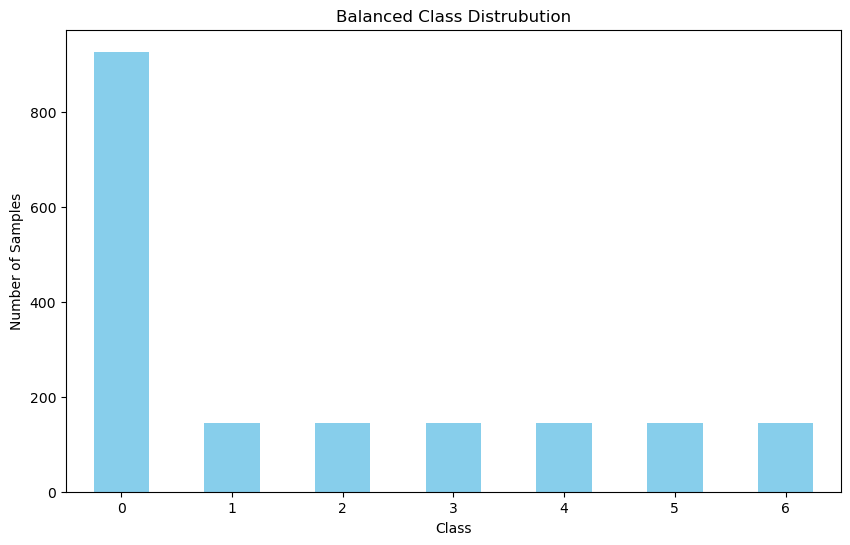

In [5]:
# Remove class 7 from the features dataframe
features_filtered = features[features['gesture'] != 7]

# Get the number of samples for the smallest class (excluding class 0)
min_class_count = features_filtered['gesture'].value_counts().min()

# Subsample class 0 to have the same number of samples as the smallest class
class_0_indices = features_filtered[features_filtered['gesture'] == 0].index
subsampled_class_0_indices = np.random.choice(class_0_indices, min_class_count, replace=False)

# Get the indices of all other classes
other_class_indices = features_filtered[features_filtered['gesture'] != 0].index

# Combine the subsampled class 0 indices with the other class indices
new_indices = np.concatenate([subsampled_class_0_indices, other_class_indices])

# Create the new features dataframe
features_balanced = features_filtered.loc[new_indices]

# Display the class distribution of the new features dataframe
plt.figure(figsize=(10, 6))
features_filtered['gesture'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Balanced Class Distrubution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.show()

In [6]:
# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(features_filtered.drop(columns=['gesture']), features_filtered['gesture'], test_size=0.15, random_state=42)
# Display the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
# Reset indices of the resulting datasets
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)



X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

X_train shape: (1521, 120)
X_test shape: (269, 120)
y_train shape: (1521,)
y_test shape: (269,)


In [7]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Use the same scaler to transform the test data
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrame for better readability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [8]:
# Initialize the Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model using the scaled training data
logistic_model.fit(X_train_scaled, y_train)

# Print the training accuracy
train_accuracy = logistic_model.score(X_train_scaled, y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

conf_matrix_lr, class_report_lr = test_model(logistic_model, X_test_scaled, y_test)


Training Accuracy: 0.9582
Confusion Matrix:
[[131   9   0   0   0   0   1]
 [  2  16   0   0   0   0   0]
 [  0   0  16   0   0   0   1]
 [  3   0   0  17   0   0   2]
 [  0   0   0   0  20   1   0]
 [  0   0   3   2   4  16   0]
 [  1   0   0   8   0   0  16]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       141
           1       0.64      0.89      0.74        18
           2       0.84      0.94      0.89        17
           3       0.63      0.77      0.69        22
           4       0.83      0.95      0.89        21
           5       0.94      0.64      0.76        25
           6       0.80      0.64      0.71        25

    accuracy                           0.86       269
   macro avg       0.81      0.82      0.80       269
weighted avg       0.88      0.86      0.86       269



In [9]:
from sklearn.neural_network import MLPClassifier

# Initialize the MLP model
mlp_model = MLPClassifier(hidden_layer_sizes=(200, 200), max_iter=1000, random_state=42)

# Train the model using the scaled training data
mlp_model.fit(X_train_scaled, y_train)

# Print the training accuracy
train_accuracy_mlp = mlp_model.score(X_train_scaled, y_train)
print(f"Training Accuracy (MLP): {train_accuracy_mlp:.4f}")

conf_matrix_mlp, class_report_mlp = test_model(mlp_model, X_test_scaled, y_test)


#  K cluster
# SVM

#Ridge
#Lasso


Training Accuracy (MLP): 0.9729
Confusion Matrix:
[[137   4   0   0   0   0   0]
 [  9   9   0   0   0   0   0]
 [  0   0  16   0   0   0   1]
 [  1   0   1  19   0   0   1]
 [  0   0   0   0  21   0   0]
 [  0   0   2   0   2  21   0]
 [  1   0   0   5   0   0  19]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       141
           1       0.69      0.50      0.58        18
           2       0.84      0.94      0.89        17
           3       0.79      0.86      0.83        22
           4       0.91      1.00      0.95        21
           5       1.00      0.84      0.91        25
           6       0.90      0.76      0.83        25

    accuracy                           0.90       269
   macro avg       0.87      0.84      0.85       269
weighted avg       0.90      0.90      0.90       269

